## Declaração de bibliotecas e demais configurações

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import csv
import matplotlib.gridspec as gridspec

from sklearn.neural_network import MLPClassifier

from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Funções relacionadas ao método ou auxiliares

In [11]:
#Função de leitura dos dados------------------------------------
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack( (data , np.asarray(row).astype(np.float) ) )
            except:
                data = np.asarray(row).astype(np.float)
    f.close()
    y = data[:,0]
    x = data[:,1:]
    return y,x

## Leitura dos dados
* Os dados considerados aqui foram obtidos do Observatório de Alagamento de Dartmounth (http://www.dartmouth.edu)

* Atributos são: Classe(indice-classe),Longitude,Latitute,Severidade,Duração (dias),Área afetada ($km^2$), Magnitude
* Maginitde = $log(Severidade \times Duracao \times Area\_afetada)$

* Classes: 
    * 1 - Chuva forte; (azul escuro)
    * 2 - Derretimento de gelo; (ciano)
    * 3 - Chuva torrencial; (verde)
    * 4 - Chuva de monção; (laranja)
    * 5 - Outros (ciclone, tornado, questões relacionadas a barragens e gelo) (magenta)

In [12]:
#Dados de treinamento
path = 'FloodData.csv'

#Leitura dos dados
y,x_ = read_class_data(path)

## Normalizar os dados, no caso do MLP é fundamental!

In [14]:
x = np.copy(x_) #Cópia da variável
AtributosNormalizar = [2,3,4,5]
for i in AtributosNormalizar:
    mi = x[:,i].min()
    ma = x[:,i].max()
    a = 1/(ma-mi)
    b = -mi/(ma-mi)
    x[:,i] = a*x[:,i] + b

## Separação aleatória dos dados para treinamento e avaliação
* Veremos ainda processos mais sofisticados que este (apesar deste ser útil também!)
* É definida uma porcentagem destinada para avaliação, e restante é usado para treino
* Tal divisão é aleatoria:
    * Uma sequência de tamanho equivalente a quantidade de dados e gerada
    * Em seguida, tal sequência é ordenada e o índice que define a ordenação é considerado
    * A primeira parcela de P% dos dados é usado para avaliação e (100-P)% para treino

In [15]:
#np.random.seed(12345) #Deseja fixar a semente geradora de números aleatórios?

#Gerar conjunto de treino e avaliação a partir de uma única fonte
N = y.shape[0]
percentAvalia = 0.33

#A ordenação dos valores aleatórios segundo seu índice/argumento
#O resultado é uma nova ordem aleatória (mais conveniente para este caso)
posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0] ))

#Subconjunto de avaliação
yI = y[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] ]
xI = x[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] , :]

#Subconjunto de treino
yD = y[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] ]
xD = x[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] , :]

In [16]:
np.int64( np.unique(yD) )

array([1, 2, 3, 4, 5])

## Visualizacão dos dados de treino/avaliação

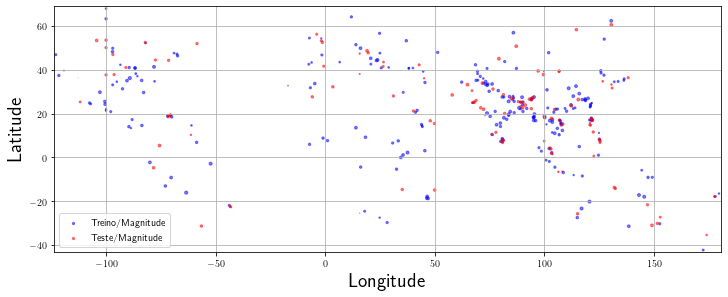

In [17]:
FS = (10,10) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])

ax.scatter( xD[:,0], xD[:,1], s=xD[:,5]*10, c='blue', alpha=0.5, label='Treino/Magnitude')
ax.scatter( xI[:,0], xI[:,1], s=xI[:,5]*10, c='red', alpha=0.5, label='Teste/Magnitude')
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')

ax.legend(fontsize=10)
ax.grid(True)

## Visualizacão dos dados de treino/classe

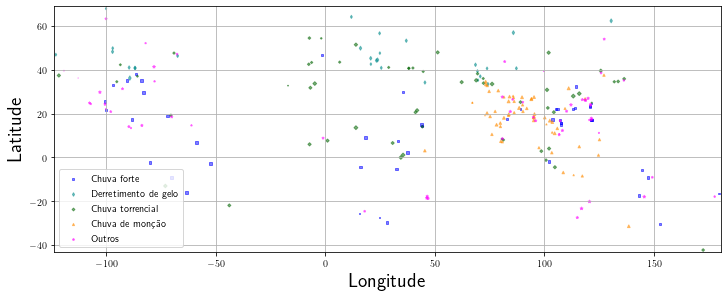

In [18]:
#Usado na estilização do gráfico
indClasse = [1,2,3,4,5]
cores = ['blue', 'darkcyan', 'darkgreen', 'darkorange', 'magenta']
simbolos = ['s', 'd', 'D', '^', '*']
nomes = ['Chuva forte', 'Derretimento de gelo', 'Chuva torrencial', 'Chuva de monção', 'Outros']

FS = (10,10) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

for i,cor,simb,rotulo in zip(indClasse,cores,simbolos,nomes):
    pos = np.where(yD == i)[0]
    ax.scatter( xD[pos,0], xD[pos,1], s=xD[pos,5]*10, c=cor, marker=simb, alpha=0.5, label=rotulo)
    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')

ax.legend()
ax.grid(True)

## Classificação dos dados
#### Diferentes arquiteturas (segundo $\texttt{hidden_layer_sizes}$):
* (6) -- 1 camada escondida com 6 neurônios $\rightarrow g_1$
* (3,3) -- 2 camadas escondidas com 3 neurônios cada $\rightarrow g_2$
* (2,2,2) -- 3 camadas escondidas com 2 neurônios cada $\rightarrow g_3$

Outros parâmetros mantidos constantes - Observe!

In [30]:
#Arquiteturas consideradas
arq1 = (3,2)
arq2 = (3,3)
arq3 = (2,2,2)

#Instanciação dos classificadores
g1 = MLPClassifier(hidden_layer_sizes=arq1, solver='lbfgs', max_iter=10000,
    activation='logistic', learning_rate='constant', shuffle=True, random_state=1)

g2 = MLPClassifier(hidden_layer_sizes=arq2, solver='lbfgs', max_iter=10000,
    activation='logistic', learning_rate='constant', shuffle=True, random_state=1)

g3 = MLPClassifier(hidden_layer_sizes=arq3, solver='lbfgs', max_iter=10000,
    activation='logistic', learning_rate='constant', shuffle=True, random_state=1)

#0- Longitude, 1 - Latitute (geralmente, não devemos usar...)
#2 - Severidade, 3 - Duração (dias), 4- Área afetada (𝑘𝑚2), 5 - Magnitude
atributos = [2,3,4,5] #Permite escolher qual atributo usar
xD_sub = xD[:,atributos]
xI_sub = xI[:,atributos]

#Treinamento dos classificadores 
g1.fit(xD_sub,yD)
g2.fit(xD_sub,yD)
g3.fit(xD_sub,yD)

MLPClassifier(activation='logistic', hidden_layer_sizes=(2, 2, 2),
              max_iter=10000, random_state=1, solver='lbfgs')

## Avaliação do desempenho
* Análise baseada na concordância (%) entre Predição $vs$ Esperado.

In [31]:
#Predição efetuada por cada uma das redes
yEst_g1 = g1.predict(xI_sub)
yEst_g2 = g2.predict(xI_sub)
yEst_g3 = g3.predict(xI_sub)

#Concordâncias...
concord_g1 = np.count_nonzero(yEst_g1 == yI) / yI.shape[0]
concord_g2 = np.count_nonzero(yEst_g2 == yI) / yI.shape[0]
concord_g3 = np.count_nonzero(yEst_g3 == yI) / yI.shape[0]

print('Rede 1: ', concord_g1)
print('Rede 2: ', concord_g2)
print('Rede 3: ', concord_g3)

Rede 1:  0.4015748031496063
Rede 2:  0.33858267716535434
Rede 3:  0.2204724409448819


## Qual classe acerta/erra mais? (com relação à melhor classificação acima)

In [36]:
for i,rotulo in zip(indClasse,nomes):
    posClasse = np.where(yI == i)[0]
    acc = np.count_nonzero(yEst_g1[posClasse] == yI[posClasse]) / yI[posClasse].shape[0]
    print(rotulo,': ',str(acc*100),'')

Chuva forte :  0.0 
Derretimento de gelo :  5.88235294117647 
Chuva torrencial :  53.333333333333336 
Chuva de monção :  75.86206896551724 
Outros :  12.903225806451612 


# Atividade:
* Faça uma representação espacial para os padrões classificados de forma correta (azul) e incorreta (vermelho)
* Teste outras arquiteturas de rede a fim de melhorar a acurácia da classificação 
* Para maiores detalhes sobre os parâmetros: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html